In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

#Model-specific imports
from SBM_SDE import *
import obs_and_flow as new

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
temp_ref = 283

#System parameters from deterministic CON model
u_M = 0.002
a_SD = 0.33
a_DS = 0.33
a_M = 0.33
a_MSC = 0.5
k_S_ref = 0.000025
k_D_ref = 0.005
k_M_ref = 0.0002
Ea_S = 75
Ea_D = 50
Ea_M = 50

#SCON diffusion matrix parameters
c_SOC = 2
c_DOC = 0.05
c_MBC = 0.1
s_SOC = 0.1
s_DOC = 0.1
s_MBC = 0.1

SCON_C_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC}
SCON_SS_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC}

#System parameters from deterministic AWB model
u_Q_ref = 0.2
Q = 0.002
a_MSA = 0.5
K_D = 200
K_U = 1
V_D_ref = 0.4
V_U_ref = 0.02
Ea_V_D = 75
Ea_V_U = 50
r_M = 0.0004
r_E = 0.00001
r_L = 0.0005

#SAWB diffusion matrix parameters
c_SOC = 2
c_DOC = 0.05
c_MBC = 0.1
c_EEC = 0.01
s_SOC = 0.1
s_DOC = 0.1
s_MBC = 0.1
s_EEC = 0.1

SAWB_C_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC, 'c_EEC': c_EEC}
SAWB_SS_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC, 's_EEC': s_EEC}

#System parameters from deterministic AWB-ECA model
u_Q_ref = 0.2
Q = 0.002
a_MSA = 0.5
K_DE = 200
K_UE = 1
V_DE_ref = 0.4
V_UE_ref = 0.02
Ea_V_DE = 75
Ea_V_UE = 50
r_M = 0.0004
r_E = 0.00001
r_L = 0.0005

#SAWB-ECA diffusion matrix parameters
c_SOC = 2
c_DOC = 0.05
c_MBC = 0.1
c_EEC = 0.01
s_SOC = 0.1
s_DOC = 0.1
s_MBC = 0.1
s_EEC = 0.1

SAWB_ECA_C_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 'c_SOC': c_SOC, 'c_DOC': c_DOC, 'c_MBC': c_MBC, 'c_EEC': c_EEC}
SAWB_ECA_SS_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC, 's_EEC': s_EEC}

In [4]:
def temp_func(t):
    temp = temp_ref + t / (20 * 24 * 365) + 10 * np.sin((2 * np.pi / 24) * t) + 10 * np.sin((2 * np.pi / (24 * 365)) * t)
    return temp

def I_S_func(t):
    return 0.001 + 0.0005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous SOC input function

def I_D_func(t):
    return 0.0001 + 0.00005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous DOC input function

def arrhenius_temp(parameter, temp, Ea, temp_ref):
    '''
    For a parameter with Arrhenius temperature dependence, returns the transformed parameter value.
    0.008314 is the gas constant. Temperatures are in K.
    '''
    decayed_parameter = parameter * np.exp(-Ea / 0.008314 * (1 / temp - 1 / temp_ref))
    return decayed_parameter

def linear_temp(parameter, temp, Q, temp_ref):
    '''
    For a parameter with linear temperature dependence, returns the transformed parameter value.
    Q is the slope of the temperature dependence and is a varying parameter.
    Temperatures are in K.
    '''
    modified_parameter = parameter - Q * (temp - temp_ref)
    return modified_parameter

#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    #Evolve drift.
    SOC = I_S + SCON_params_dict['a_DS'] * k_D * x[1] + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * x[2] - k_S * x[0]
    DOC = I_D + SCON_params_dict['a_SD'] * k_S * x[0] + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * x[2] - (SCON_params_dict['u_M'] + k_D) * x[1]
    MBC = SCON_params_dict['u_M'] * x[1] - k_M * x[2]
    return np.array([SOC, DOC, MBC])

def beta_SCON_C(x, SCON_C_params_dict):
    b11 = SCON_C_params_dict['c_SOC']
    b22 = SCON_C_params_dict['c_DOC']
    b33 = SCON_C_params_dict['c_MBC']
    return np.diag([b11, b22, b33])

def beta_SCON_SS(x, SCON_SS_params_dict):
    b11 = SCON_SS_params_dict['s_SOC'] * x[0]
    b22 = SCON_SS_params_dict['s_DOC'] * x[1]
    b33 = SCON_SS_params_dict['s_MBC'] * x[2]
    return np.diag([b11, b22, b33])

def alpha_SAWB(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * x[2] - ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0]))
    DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * x[2] + ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0])) + SAWB_params_dict['r_L'] * x[3] - ((V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1]))
    MBC = (u_Q * (V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1])) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * x[2]
    EEC = SAWB_params_dict['r_E'] * x[2] - SAWB_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_C(x, SAWB_C_params_dict):
    b11 = SAWB_C_params_dict['c_SOC']
    b22 = SAWB_C_params_dict['c_DOC']
    b33 = SAWB_C_params_dict['c_MBC']
    b44 = SAWB_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_SS(x, SAWB_SS_params_dict):
    b11 = SAWB_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

def alpha_SAWB_ECA(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * x[2] - ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0]))
    DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * x[2] + ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0])) + SAWB_ECA_params_dict['r_L'] * x[3] - ((V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1]))
    MBC = (u_Q * (V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1])) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * x[2]
    EEC = SAWB_ECA_params_dict['r_E'] * x[2] - SAWB_ECA_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_ECA_C(x, SAWB_ECA_C_params_dict):
    b11 = SAWB_ECA_C_params_dict['c_SOC']
    b22 = SAWB_ECA_C_params_dict['c_DOC']
    b33 = SAWB_ECA_C_params_dict['c_MBC']
    b44 = SAWB_ECA_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_ECA_SS(x, SAWB_ECA_SS_params_dict):
    b11 = SAWB_ECA_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_ECA_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_ECA_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_ECA_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])
    
def get_SBM_SDE_euler_maruyama_y(ALPHA, BETA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, OBS_EVERY, OBS_ERROR_SCALE, model_fam):
    state_dim = 0
    if model_fam == 'SCON':
        state_dim = 3
    elif model_fam == 'SAWB':
        state_dim = 4
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    x[:, 0] = X0
    hour = 0
    for i in range(1, N):
        hour += DT
        #print('hour', hour)
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour)
        #print('current_temp', current_temp)
        #Take Euler-Maruyama step. Note: np.random.normal takes std while np.random.multivariate_normal takes cov.
        x[:, i] = np.random.multivariate_normal(mean = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp) * DT, cov = BETA(x[:, i - 1], THETA_DICT) * DT)
        x[:, i][x[:, i] < 1e-5] = 1e-5 #Bound all x above 0.
        #print('x at i', x[:, i])
    x_for_y = x[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_for_y.mean(1)
    y = x_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_for_y.shape) #Introduce observation error based on mean size of y.
    y[y < 1e-5] = 1e-5 #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'x': x, 'y_std': obs_var_scale, 'x': x, 't_x': np.arange(0, T + DT, DT)}

In [5]:
#Set SDE y generation parameters.

dt = 0.01
t = 1500
x0_SCON = [38.5, 0.2, 0.9]
obs_every = 5
obs_error_scale = 0.1

In [6]:
#Obtain y from Euler-Maruyama integration scheme for SDE.
y_dict = get_SBM_SDE_euler_maruyama_y(alpha_SCON, beta_SCON_C, x0_SCON, t, dt, SCON_C_params_dict, I_S_func, I_D_func, temp_func, obs_every, obs_error_scale, 'SCON')

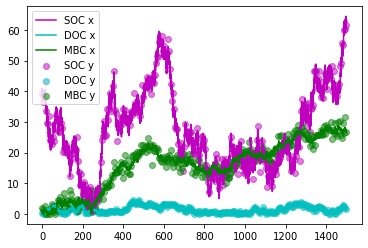

In [7]:
#Plot y.
fig, axs = plt.subplots(1, 1)
axs.plot(y_dict['t_x'], y_dict['x'][0, :], color = 'm', label = 'SOC x')
axs.plot(y_dict['t_x'], y_dict['x'][1, :], color = 'c', label = 'DOC x')
axs.plot(y_dict['t_x'], y_dict['x'][2, :], color = 'g', label = 'MBC x')
axs.scatter(y_dict['t_y'], y_dict['y'][0, :], color = 'm', alpha = 0.5, label = 'SOC y')
axs.scatter(y_dict['t_y'], y_dict['y'][1, :], color = 'c', alpha = 0.5, label = 'DOC y')
axs.scatter(y_dict['t_y'], y_dict['y'][2, :], color = 'g', alpha = 0.5, label = 'MBC y')
axs.legend()

In [14]:
#Set flow NN parameters.

devi = torch.device("".join(["cuda:",f'{cuda_id}']) if torch.cuda.is_available() else "cpu")
dt_flow = 0.2
n_flow = int(t / dt_flow) 
t_span = np.linspace(0, t, n_flow + 1)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n_flow + 1, 1]) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.
l_r = 1e-4
niter = 11
piter = 1
batch_size = 2 #Number of sets of observation outputs to sample per set of parameters.
state_dim_SCON = 3 #Not including CO2 in STATE_DIM, because CO2 is an observation.

In [15]:
#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = 0.001 + 0.0005 * torch.sin((2 * np.pi / (24 * 365)) * t_span_tensor) #Exogenous SOC input function
i_d_tensor = 0.0001 + 0.00005 * torch.sin((2 * np.pi / (24 * 365)) * t_span_tensor) #Exogenous DOC input function

In [16]:
def calc_log_lik(C_PATH, T_SPAN_TENSOR, DT, I_S_TENSOR, I_D_TENSOR, DRIFT_DIFFUSION, PARAMS_DICT, TEMP_GEN, TEMP_REF):
    drift, diffusion_sqrt = DRIFT_DIFFUSION(C_PATH[:, :-1, :], T_SPAN_TENSOR[:, :-1, :], I_S_TENSOR[:, :-1, :], I_D_TENSOR[:, :-1, :], PARAMS_DICT, TEMP_GEN, TEMP_REF)
    euler_maruyama_state_sample_object =D.multivariate_normal.MultivariateNormal(loc = C_PATH[:, :-1, :] + drift * DT, scale_tril = diffusion_sqrt * math.sqrt(DT))
    return euler_maruyama_state_sample_object.log_prob(C_PATH[:, 1:, :]).sum(-1)

In [19]:
def train_new_flow(DEVICE, L_R, NITER, PRETRAIN_ITER, BATCH_SIZE, SDEFLOW, ObsModel, Y_DICT, STATE_DIM, T, DT, N, T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, DRIFT_DIFFUSION, PARAMS_DICT, TEMP_GEN, TEMP_REF, C0): 
    obs_model = ObsModel(DEVICE, Y_DICT['t_y'], DT, torch.Tensor(Y_DICT['y']).to(DEVICE), torch.Tensor(Y_DICT['y_std']).to(DEVICE)) #Hack for bypassing ObsModel and SDEFlow dimension mismatch issue.
    net = SDEFLOW(DEVICE, obs_model, STATE_DIM, T, DT, N, I_S_TENSOR, I_D_TENSOR, cond_inputs = 3).to(DEVICE) #For obs_and_flow.py
    optimizer = optim.Adam(net.parameters(), lr = L_R) 
    if PRETRAIN_ITER >= NITER:
        raise Exception("PRETRAIN_ITER must be < NITER.")
    best_loss_norm = 1e10
    best_loss_ELBO = 1e10
    norm_losses = [best_loss_norm] * 10
    ELBO_losses = [best_loss_ELBO] * 10
    C0 = torch.Tensor(C0).to(DEVICE)
    C0 = C0[(None,) * 2].repeat(BATCH_SIZE, 1, 1).to(DEVICE)
    PARAMS_DICT_TENSOR = {k: torch.tensor(v).expand(BATCH_SIZE) for k, v in PARAMS_DICT.items()}
    with tqdm(total = NITER, desc = f'Train Diffusion', position = -1) as tq:
        for i in range(NITER):
            net.train()
            optimizer.zero_grad()
            C_PATH, log_prob = net(BATCH_SIZE) #For obs_and_flow.py
            C_PATH = torch.cat([C0, C_PATH], 1) #Append deterministic CON initial conditions conditional on parameter values to C path. 
            if i <= PRETRAIN_ITER:
                l1_norm_element = C_PATH - torch.mean(obs_model.mu, -1)
                l1_norm = torch.sum(torch.abs(l1_norm_element)).mean()
                best_loss_norm = l1_norm if l1_norm < best_loss_norm else best_loss_norm
                norm_losses.append(l1_norm.item())
                #l2_norm_element = C_PATH - torch.mean(obs_model.mu, -1)
                #l2_norm = torch.sqrt(torch.sum(torch.square(l2_norm_element))).mean()
                #best_loss_norm = l2_norm if l2_norm < best_loss_norm else best_loss_norm
                #norm_losses.append(l2_norm.item())
                if i % 10 == 0:
                    ma_norm_loss = sum(norm_losses[-10:]) / len(norm_losses[-10:])
                    print(f"\nMoving average norm loss at {iter} iterations is: {ma_norm_loss}. Best norm loss value is: {best_loss_norm}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\nC_PATH =', C_PATH)
                l1_norm.backward()
                #l2_norm.backward()
            else:
                log_lik = calc_log_lik(C_PATH, T_SPAN_TENSOR.to(DEVICE), DT, I_S_TENSOR.to(DEVICE), I_D_TENSOR.to(DEVICE), DRIFT_DIFFUSION, PARAMS_DICT, TEMP_GEN, TEMP_REF)
                neg_ELBO = -log_lik.mean() - obs_model(C_PATH, PARAMS_DICT_TENSOR) + log_prob.mean()
                best_loss_ELBO = neg_ELBO if neg_ELBO < best_loss_ELBO else best_loss_ELBO
                ELBO_losses.append(neg_ELBO.item())
                if i % 10 == 0:             
                    ma_elbo_loss = sum(ELBO_losses[-10:]) / len(ELBO_losses[-10:])
                    print(f"\nMoving average ELBO loss at {iter} iterations is: {ma_elbo_loss}. Best ELBO loss value is: {best_loss_ELBO}.")
                    print('\nC_PATH mean =', C_PATH.mean(-2))
                    print('\nC_PATH =', C_PATH)
            torch.nn.utils.clip_grad_norm_(net.parameters(), 3.0)
            optimizer.step()
            if i % 100000 == 0 and i > 0:
                optimizer.param_groups[0]['lr'] *= 0.1
            tq.update()
    return net, ELBO_losses, norm_losses

In [20]:
train_new_flow(devi, l_r, niter, piter, batch_size, new.SDEFlow, new.ObsModel, y_dict, state_dim_SCON, t, dt_flow, n_flow, t_span_tensor, i_s_tensor, i_d_tensor, drift_diffusion_SCON_C, SCON_C_params_dict, temp_gen, temp_ref, x0_SCON)


Train Diffusion:   0%|          | 0/11 [00:00<?, ?it/s]


Moving average norm loss at <built-in function iter> iterations is: 9000063384.74375. Best norm loss value is: 633847.4375.

C_PATH mean = tensor([[1.0209, 0.7621, 0.6368],
        [1.0181, 0.7632, 0.6371]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[38.5000,  0.2000,  0.9000],
         [ 1.1979,  0.7663,  0.6347],
         [ 1.1680,  0.7355,  0.6287],
         ...,
         [ 1.1131,  0.6272,  0.5923],
         [ 0.9517,  0.6530,  0.7676],
         [ 0.6638,  0.6282,  3.4427]],

        [[38.5000,  0.2000,  0.9000],
         [ 1.1979,  0.6615,  0.7645],
         [ 1.1820,  0.9268,  0.7453],
         ...,
         [ 0.6869,  0.7465,  0.6423],
         [ 0.8432,  0.6962,  0.6179],
         [ 1.0292,  0.7410,  3.5028]]], grad_fn=<CatBackward>)



Train Diffusion: 100%|██████████| 11/11 [00:42<00:00,  3.88s/it]


Moving average ELBO loss at <built-in function iter> iterations is: 1000792454.35. Best ELBO loss value is: 850113.5625.

C_PATH mean = tensor([[1.1437, 0.7307, 0.5759],
        [1.1471, 0.7286, 0.5765]], grad_fn=<MeanBackward1>)

C_PATH = tensor([[[38.5000,  0.2000,  0.9000],
         [ 0.9650,  0.8232,  0.6291],
         [ 1.4670,  0.8356,  0.7240],
         ...,
         [ 1.0176,  0.7217,  0.5161],
         [ 0.9878,  0.6453,  0.7280],
         [ 0.8207,  0.6519,  1.2539]],

        [[38.5000,  0.2000,  0.9000],
         [ 0.9650,  0.7925,  0.5968],
         [ 1.4645,  0.8990,  0.6027],
         ...,
         [ 0.7958,  0.5971,  0.5847],
         [ 0.8272,  0.5763,  0.6867],
         [ 1.0398,  0.5854,  1.1379]]], grad_fn=<CatBackward>)


(SDEFlow(
   (obs_model): ObsModel()
   (coupling): ModuleList(
     (0): CouplingLayer(
       (feature_net): Sequential(
         (0): ResNetBlockUnMasked(
           (conv1): Conv1d(6, 96, kernel_size=(3,), stride=(1,), padding=(1,))
           (conv2): Conv1d(96, 96, kernel_size=(3,), stride=(1,), padding=(1,))
           (act1): PReLU(num_parameters=96)
           (act2): PReLU(num_parameters=96)
           (bn1): Identity()
           (bn2): Identity()
           (conv_skip): Conv1d(6, 96, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
         )
         (1): ResNetBlockUnMasked(
           (conv1): Conv1d(96, 6, kernel_size=(3,), stride=(1,), padding=(1,))
           (conv2): Conv1d(6, 6, kernel_size=(3,), stride=(1,), padding=(1,))
           (act1): PReLU(num_parameters=6)
           (act2): PReLU(num_parameters=6)
           (bn1): Identity()
           (bn2): Identity()
           (conv_skip): Conv1d(96, 6, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
